<a href="https://colab.research.google.com/github/AkshayTries/FashionRec-FC63/blob/main/Recommend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentence_transformers
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sentence_transformers import SentenceTransformer, util
from sklearn.neighbors import NearestNeighbors
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.5 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=65323f4f6f0d6feb23cca1f10febfd0852afcd967a3ccc2d5579b875dd57bb50
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [3]:
model = SentenceTransformer('stsb-distilbert-base')
model.max_seq_length = 128

In [4]:
with open("/content/textembedding.pkl", 'wb') as file:
    pickle.dump(model, file)

In [5]:
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
img_model = tf.keras.applications.MobileNet(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = 'imagenet' )
with open("/content/mobilenet.pkl", 'wb') as file:
    pickle.dump(img_model, file)

17225924/17225924 [==============================] - 2s 0us/step


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
def get_textEmbeddings(model,text):
    text_embedding = model.encode(text, convert_to_tensor=True)
    return text_embedding

In [8]:
def get_imageEmbeddings(model,imagePath):
    image = tf.keras.preprocessing.image.load_img(imagePath,target_size= size)
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    img_embeddings = model(input_arr)
    meanImgEmb1 = np.mean(img_embeddings,axis =0)
    meanImgEmb2 = np.mean(meanImgEmb1,axis=0)
    meanImgEmb = np.mean(meanImgEmb2,axis=0)
    return meanImgEmb

In [9]:
train_df = pd.read_excel("/content/drive/MyDrive/outfits.xlsx")

In [10]:
train_df.head(5)

,Product,Gender,style,weather,match
0,whiteshirt.jpg,male,formal,hot,blackpant.jpg
1,whiteshirt.jpg,male,formal,hot,bluepant.jpg
2,whitetshirt.jpg,male,casual,cold,blackjeans.jpg
3,whitetshirt.jpg,male,casual,cold,bluejeans.jpg
4,whitetshirt.jpg,male,casual,hot,whitepant.jpg


In [11]:
y= train_df.loc[:,"match"]

In [12]:
y.head(5)

0     blackpant.jpg
1      bluepant.jpg
2    blackjeans.jpg
3     bluejeans.jpg
4     whitepant.jpg
Name: match, dtype: object

In [13]:
gender_embeddings={}
style_embeddings={}
weather_embeddings={}
image_embeddings={}
for index,row in  train_df.iterrows():
    gender_emb = get_textEmbeddings(model,str(row[1]))
    style_emb = get_textEmbeddings(model,str(row[2]))
    weather_emb = get_textEmbeddings(model,str(row[3]))
    imagePath = '/content/drive/MyDrive/Clothes/'+row[0]
    img_emb = get_imageEmbeddings(img_model,imagePath)
    gender_embeddings[row[0]] = gender_emb
    style_embeddings[row[0]] = style_emb
    weather_embeddings[row[0]] = weather_emb
    image_embeddings[row[0]] = img_emb

In [14]:
keyList=[]
cembList=[]
imageList=[]
genderList=[]
styleList=[]
weatherList=[]
for index, row in train_df.iterrows():
    gender_emb = gender_embeddings[row[0]].cpu()
    print(np.shape(gender_emb))
    style_emb = style_embeddings[row[0]].cpu()
    print(np.shape(style_emb))
    weather_emb = weather_embeddings[row[0]].cpu()
    print(np.shape(gender_emb))
    img_emb = image_embeddings[row[0]]
    print(np.shape(img_emb))
    cmb_emb = np.concatenate((gender_emb,style_emb,weather_emb,img_emb),axis=0)
    print(np.shape(cmb_emb))
    norm = np.linalg.norm(cmb_emb)
    cmb_emb_normal = cmb_emb/norm
    keyList.append(row[0])
    cembList.append(cmb_emb_normal)
    imageList.append(row[0])
    genderList.append(row[1])
    styleList.append(row[2])
    weatherList.append(row[3])

torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
torch.Size([768])
torch.Size([768])
(1024,)
(3328,)
torch.Size([768])
to

In [15]:
from sklearn.neighbors import NearestNeighbors
kneigh = NearestNeighbors(n_neighbors=5,leaf_size=5000,algorithm='kd_tree')
kneigh.fit(cembList)

NearestNeighbors(algorithm='kd_tree', leaf_size=5000)

In [16]:
model_file = "/content/recommendmodel.pkl"

# Pickle the model
with open(model_file, 'wb') as file:
    pickle.dump(kneigh, file)

In [17]:
def getNeighbours(query_emb):
    posting_id_list=[]
    neigh_dist,neigh_ind = kneigh.kneighbors(X=query_emb.reshape(1,-1), n_neighbors=5, return_distance=True)
    for ind in neigh_ind:
        #print(str(ind))
        for ind1 in ind:
            posting_id_list.append(str(ind1))
    return posting_id_list

In [19]:
pic = "/content/Passportphoto.jpg"
gender = "male"
weather = "cold"
style = "formal"
gen_emb = get_textEmbeddings(model,gender).cpu()
sty_emb = get_textEmbeddings(model,style).cpu()
wea_emb = get_textEmbeddings(model,weather).cpu()
pic_emb = get_imageEmbeddings(img_model,pic)
combined = np.concatenate((gen_emb,sty_emb,wea_emb,pic_emb),axis=0)

In [20]:
matches = getNeighbours(combined)

In [21]:
matches

['41', '66', '59', '46', '48']

In [28]:
n = train_df.iloc[66]

In [29]:
n

Product       bluepant.jpg
Gender                male
style               casual
weather                hot
match      greentshirt.jpg
Name: 66, dtype: object

In [24]:
mat = n[4]

In [25]:
mat

'whiteshirt.jpg'

In [26]:
from google.colab.patches import cv2_imshow
import cv2

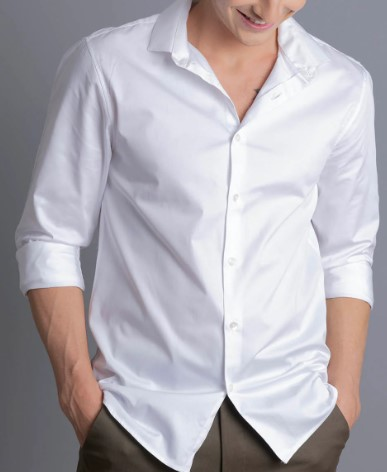

In [27]:
i = cv2.imread("/content/drive/MyDrive/Clothes/"+mat,cv2.IMREAD_UNCHANGED)
cv2_imshow(i)
